In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Off FutureWarnings
import warnings
warnings.filterwarnings('ignore')

#Resampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import class_weight

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

# Save model
import pickle

In [2]:
df = pd.read_csv(r'predictive_maintenance.csv')
pd.options.mode.chained_assignment = None
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [3]:
# Check if exist duplicate values

data_duplicates = df.duplicated().sum()
print("Total duplicated values: ", data_duplicates)

Total duplicated values:  0


In [4]:
# Check if exist missing values

data_null = df.isnull().sum().sum()
print("Total missing values: ", data_null)

Total missing values:  0


In [5]:
## Verify the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
## Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [7]:
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [8]:
## Verify the proportion of column "Failure_type"
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [9]:
# Rename the columns

rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
}
df.rename(rename_columns, axis = 1, inplace = True)

In [10]:
# Identity redundance rows
count_failures = (df['Target'] == 1).sum()
print(f"Number of failures:", count_failures)
# Sum of occurences of 'Failure Type other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target']==1), 'Failure_type'].count()
print(f"Sum of failures different of 'No Failure':, {sum_failures}")

Number of failures: 339
Sum of failures different of 'No Failure':, 330


As we can see there are 9 ambiguos values, so we need remove this.

In [11]:
# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]
# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

In [12]:
#Removing unnecessary columnds
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

In [13]:
df.Failure_type.value_counts()

Failure_type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [14]:
# remove Random Failures from Failure_type column
df = df.loc[df['Failure_type']!= 'Random Failure']

In [15]:
df.Type.value_counts()

Type
L    5996
M    2993
H    1002
Name: count, dtype: int64

In [16]:
# renaming classes of "Type" column
rename_type = {
'L':'Low',
'M':'Medium',
'H':'High'
}

df['Type'].replace(rename_type, inplace=True)

plot "Type" Distribution

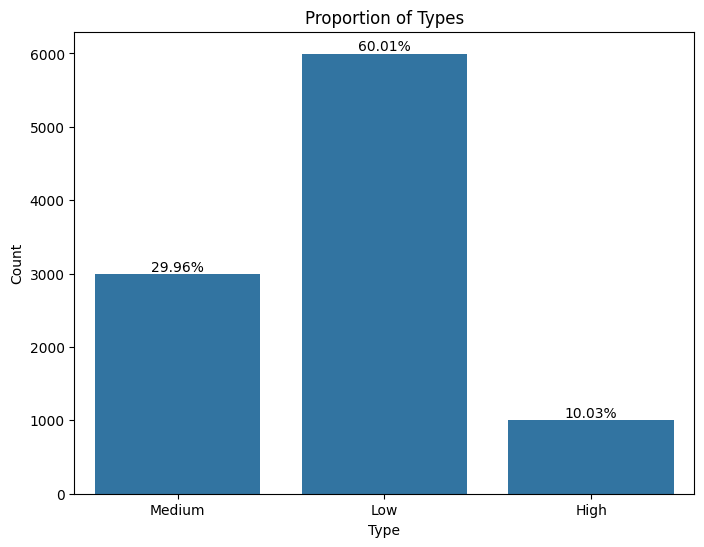

In [17]:
# count types
tipo_contagem = df['Type'].value_counts()

# show graphic
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

# Add as percentage as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

Plot “Failure_type” distribution

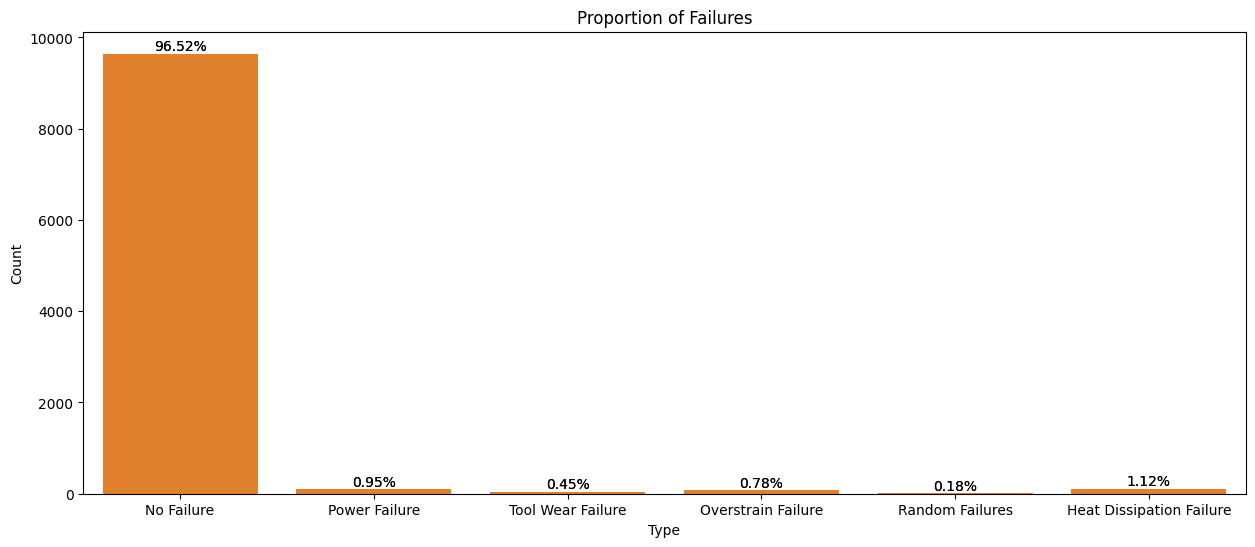

In [18]:
# Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')
ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

Plot histogram and boxplot with numeric features

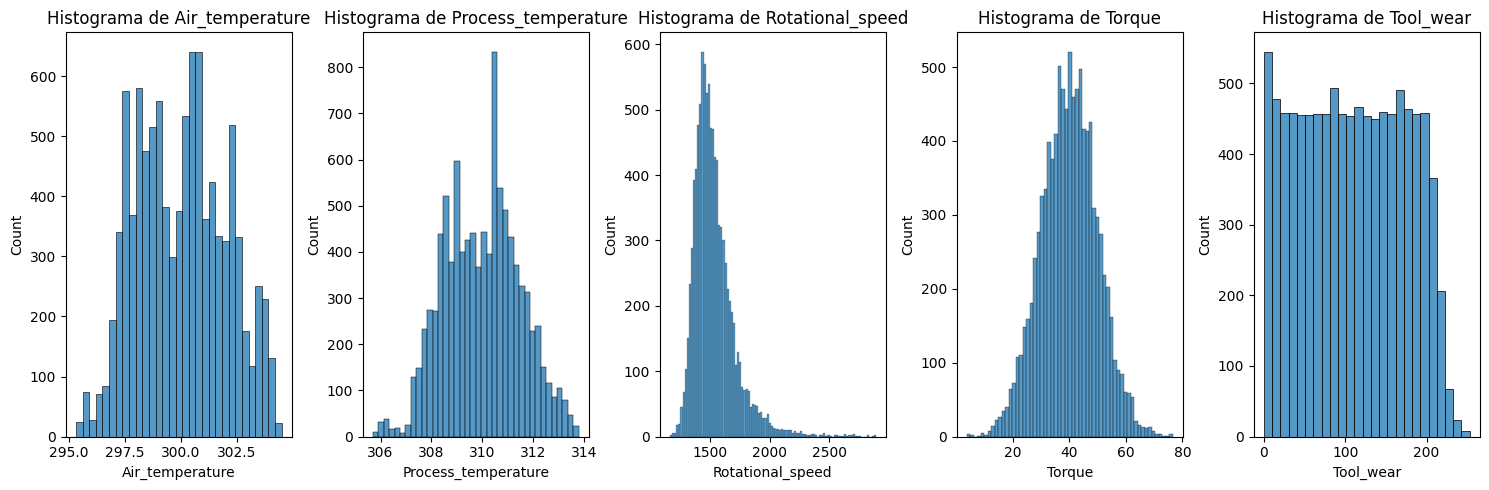

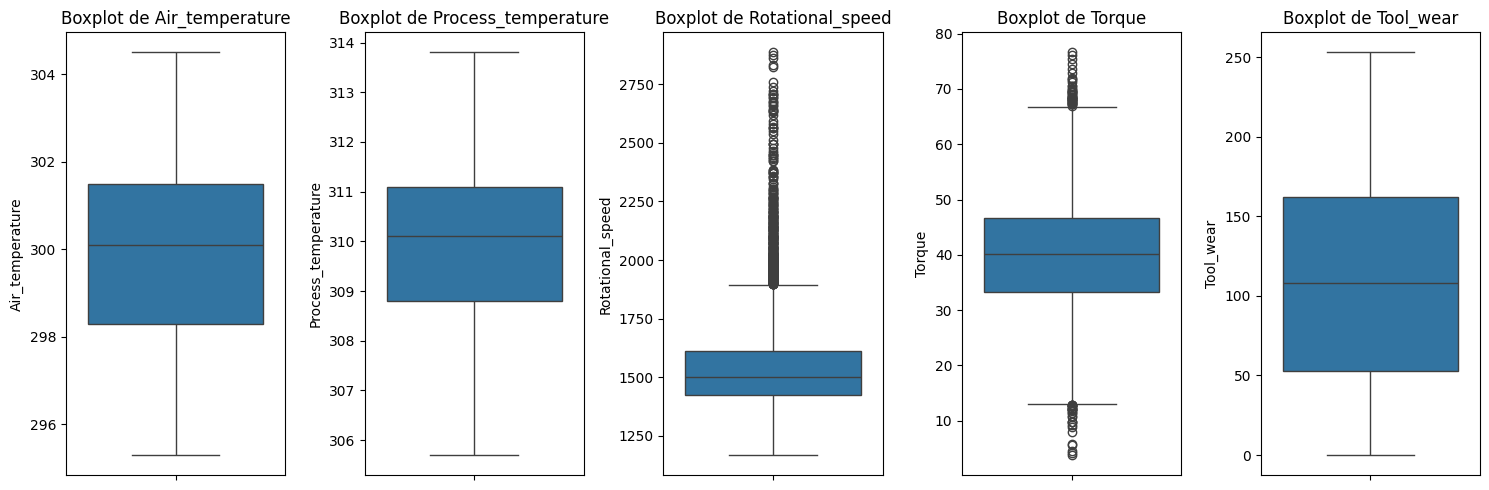

In [19]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()

Insights
1. With respect to histogram, the columns Air_temperatura, Process_temperature and torque is similar to normal distribution and rotation_speed is assimetric with negative bias. 
2. Regarding to boxplot, here it’s possible confirm the hypothesis that exist outliers is some columns as soon as mencioned in the begging of this project. However, we won’t remove this values because make sense that when a machine have one type of failure the values measurement by some sensor will increase so much. 
3. Furthermore, when the rotarional_speed increase a lot make totally sense that torque decrease too, this is a physics behavior, so the outliers detected in torque column with low values possibility is caused by this.

Plot distribution just of failures

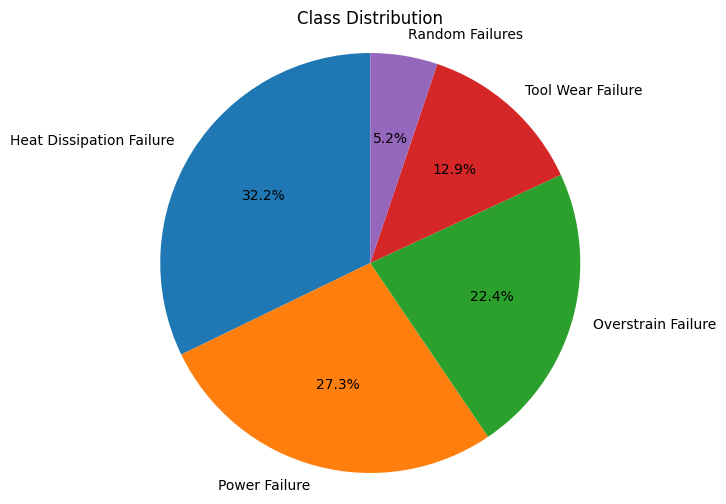

In [20]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]

proportions = df_failure_type['Failure_type'].value_counts(normalize=True)

plt.figure(figsize=(8,6))
plt.pie(proportions
        , labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()

Plot numeric correlation with heatmap

In [21]:
# corr = df.corr()
# plt.figure(figsize = (5,5))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")
df.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Failure_type
0,Medium,298.1,308.6,1551,42.8,0,No Failure
1,Low,298.2,308.7,1408,46.3,3,No Failure
2,Low,298.1,308.5,1498,49.4,5,No Failure
3,Low,298.2,308.6,1433,39.5,7,No Failure
4,Low,298.2,308.7,1408,40.0,9,No Failure


In [22]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[ 
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])
# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)
# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.952222,-0.947078,0.068015,0.282351,-1.695786,0.0,0.0,1.0
1,-0.902227,-0.879689,-0.729478,0.633456,-1.648656,0.0,1.0,0.0
2,-0.952222,-1.014468,-0.227559,0.944434,-1.617236,0.0,1.0,0.0
3,-0.902227,-0.947078,-0.590056,-0.048691,-1.585816,0.0,1.0,0.0
4,-0.902227,-0.879689,-0.729478,0.001467,-1.554395,0.0,1.0,0.0


PCA (Principal Component Analysis) reduces data dimensionality, highlights patterns and simplifies datasets, enhancing model performance and interpretability while preserving essential information. Lets check how much components explain more or less 95% of our data trought the graphic below.

In [23]:
pca = PCA()
pca.fit(df_transformed)

exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

n_pca_components = len(exp_var)

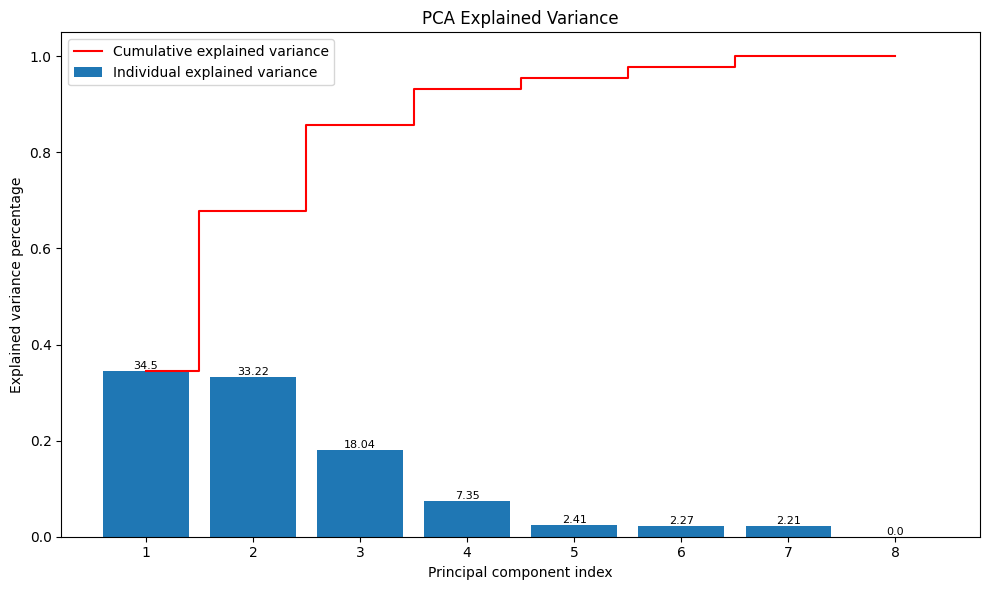

In [24]:
# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that with 4 components already explained the variability of our data around 94%. So, we can try use only this components to model and analyse if the perfomance improve. 

Plot explanation of PCA components

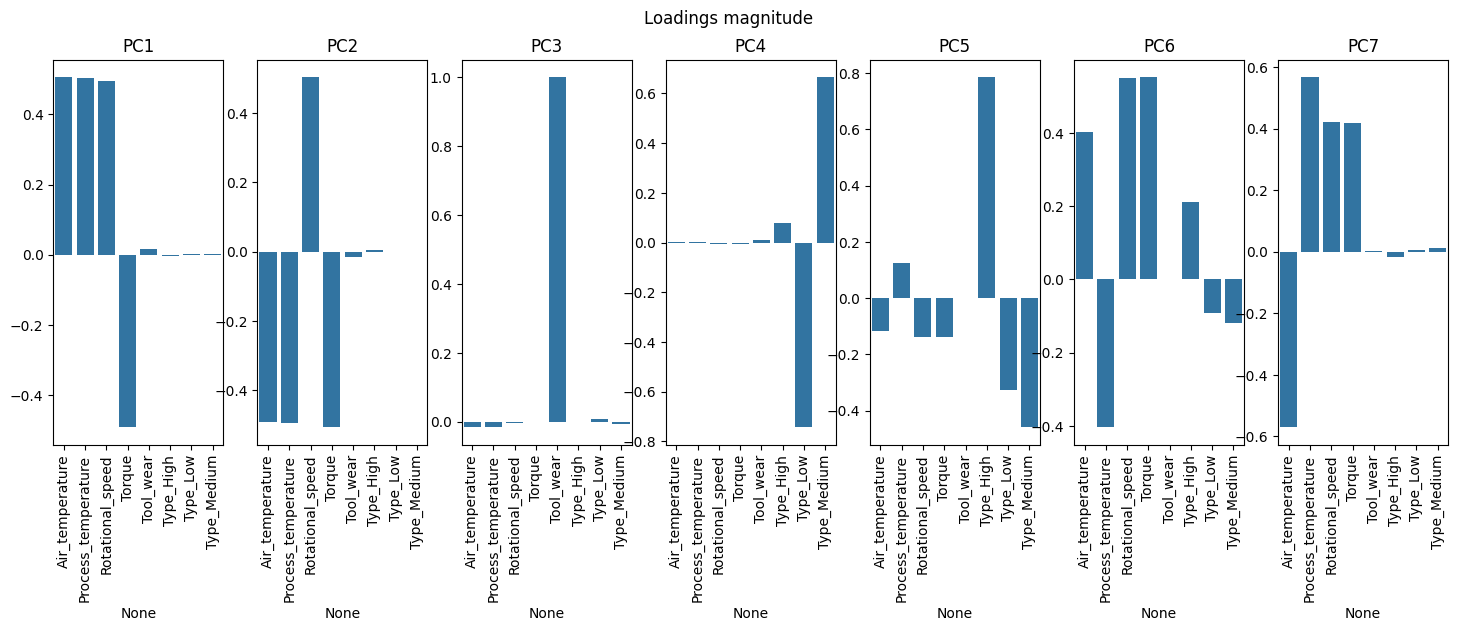

In [25]:
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do 
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

# plot the bar graphics
for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x',rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

PC1 and PC2: explained by Air_temperature, Process_temperatura, Rotational_speed and Torque; PC3: explained by Tool_wear; PC4: most explained by Type_Low and Type_Medium; PC5: most explained by Type_High; PC6: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque; PC7: most explained by Air_temperature, Process_temperatura, Rotational_speed and Torque.

Modeling

In [26]:
# Create a function to get metrics

from sklearn.metrics import f1_score

def get_metrics(y_true, y_pred):
    # Calculating F1 scores for each class
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)
    
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

In [27]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7992, 6) (1999, 6) (7992,) (1999,)


Create model with PCA and class_weight

In [29]:
# Creating pipeline with PCA analysis and balanced class
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),
    ('model', RandomForestClassifier(random_state=2023))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.967983991995998,
 'Balanced Accuracy': 0.24534155296105856,
 'Macro Recall': 0.24534155296105856,
 'Macro Precision': 0.5503603150661974,
 'Macro F1': 0.2844975488959775,
 'F1 Scores per Class': array([0.08695652, 0.98366514, 0.54545455, 0.09090909, 0.        ,
        0.        ])}

Create model without PCA and with class_weight

In [30]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9374687343671836,
 'Balanced Accuracy': 0.6161461222825511,
 'Macro Recall': 0.6161461222825511,
 'Macro Precision': 0.47367262781265335,
 'Macro F1': 0.5220700489923096,
 'F1 Scores per Class': array([0.78571429, 0.96736535, 0.56410256, 0.76190476, 0.        ,
        0.05333333])}

Create model without PCA and with SMOTE-NC

In [31]:
# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES) 
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using ImbPipeline
pip_model_smotenc = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit the pipeline
pip_model_smotenc.fit(X_train, y_train)

# Generate Predictions
y_pred = pip_model_smotenc.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9109554777388694,
 'Balanced Accuracy': 0.635039516884487,
 'Macro Recall': 0.635039516884487,
 'Macro Precision': 0.4774113967108018,
 'Macro F1': 0.5368034684427243,
 'F1 Scores per Class': array([0.78571429, 0.95227824, 0.72727273, 0.75555556, 0.        ,
        0.        ])}

GridSearchCV to find Better model

In [34]:
# Creating pipeline without PCA analysis and balanced class with parameter by model

pip_model_no_pca = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model', GradientBoostingClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(X_train, y_train, model__sample_weight=weights)

# Updated parameters for GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=500, random_state=2023),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ],
}

# Running GridSearchCV
grid = GridSearchCV(pip_model_no_pca, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Collecting and printing the results
results = pd.DataFrame(grid.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']

# View results
print("Best Model :")
print(best_model_params)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Model :
{'model': GradientBoostingClassifier(random_state=2023)}


GradientBoostingClassifier is the best model to our application in comparation with RandomForestClassifier, GradientBoostingClassifier and DummyClassifier. 

Tunning the Model

In [36]:
# New parameters for fine-tuning the RandomForestClassifier
fine_tune_params = {
    
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Finding the best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best fine-tuned model parameters:
{'model__max_depth': 5, 'model__n_estimators': 300}


{'Accuracy': 0.9804902451225613,
 'Balanced Accuracy': 0.5521341470556703,
 'Macro Recall': 0.5521341470556703,
 'Macro Precision': 0.6006311179804226,
 'Macro F1': 0.5696278038075764,
 'F1 Scores per Class': array([0.86956522, 0.99018088, 0.58064516, 0.82352941, 0.        ,
        0.15384615])}

Confusion Matrix

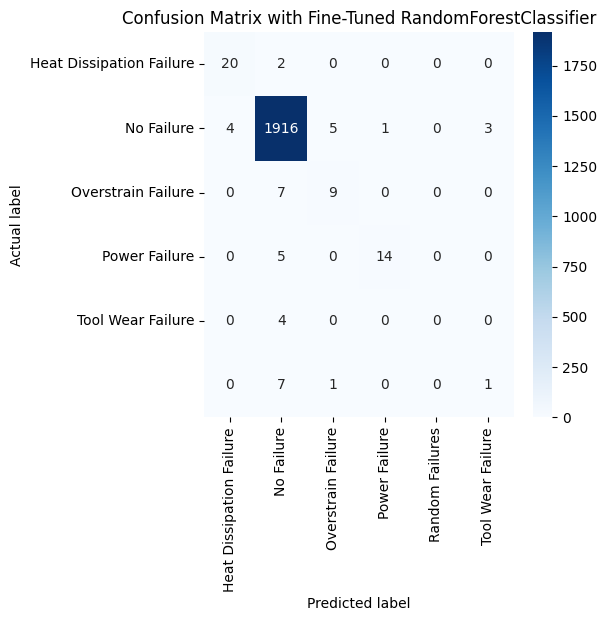

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_pred),            
            )

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()

Deplyement

In [40]:
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)